In [12]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import pre_data as eda


# 상관관계 높은 컬럼 병합

In [17]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import pre_data as eda

# 컬럼 간의 상관관계를 고려하여 PCA로 병합하는 함수
def merge_correlated_columns_with_pca(data, positive_threshold=0.1, negative_threshold=-1):
    # 상관계수 행렬 계산 (컬럼 간 상관관계)
    if 'Churn' in data.columns:
        corr_matrix = data.drop(columns=['Churn']).corr()
    else:
        corr_matrix = data.corr()

    # 양의 상관관계 그룹과 음의 상관관계 그룹을 저장할 리스트
    positive_correlated_groups = []
    negative_correlated_groups = []

    # 이미 병합된 피처들을 추적하기 위한 세트
    used_columns = set()

    for i in range(len(corr_matrix.columns)):
        if corr_matrix.columns[i] not in used_columns:
            # i번째 컬럼과 상관계수가 positive_threshold 이상인 피처 그룹 추출 (양의 상관관계)
            high_positive_corr_cols = corr_matrix.columns[corr_matrix.iloc[i] >= positive_threshold].tolist()
            high_positive_corr_cols = [col for col in high_positive_corr_cols if col not in used_columns]

            # i번째 컬럼과 상관계수가 negative_threshold 이하인 피처 그룹 추출 (음의 상관관계)
            high_negative_corr_cols = corr_matrix.columns[corr_matrix.iloc[i] <= negative_threshold].tolist()
            high_negative_corr_cols = [col for col in high_negative_corr_cols if col not in used_columns]

            # 양의 상관관계 그룹 추가
            if len(high_positive_corr_cols) > 1:
                positive_correlated_groups.append(high_positive_corr_cols)
                used_columns.update(high_positive_corr_cols)

            # 음의 상관관계 그룹 추가
            if len(high_negative_corr_cols) > 1:
                negative_correlated_groups.append(high_negative_corr_cols)
                used_columns.update(high_negative_corr_cols)

    # PCA를 사용해 상관계수가 높은 컬럼 그룹을 병합
    data_pca_merged = data.copy()

    # 양의 상관관계 그룹에 대해 PCA 적용
    for group in positive_correlated_groups:
        pca = PCA(n_components=1)
        data_pca_merged[f'{"_".join(group)}_pca_pos'] = pca.fit_transform(data[group])
        print(f"Positive Correlation Group Merged: {group} -> {'_'.join(group)}_pca_pos")
        # 기존 컬럼 제거
        data_pca_merged.drop(columns=group, inplace=True)

    # 음의 상관관계 그룹에 대해 PCA 적용
    for group in negative_correlated_groups:
        pca = PCA(n_components=1)
        data_pca_merged[f'{"_".join(group)}_pca_neg'] = pca.fit_transform(data[group])
        print(f"Negative Correlation Group Merged: {group} -> {'_'.join(group)}_pca_neg")
        # 기존 컬럼 제거
        data_pca_merged.drop(columns=group, inplace=True)

    return data_pca_merged, positive_correlated_groups, negative_correlated_groups

# 예시 데이터 로드 (실제 데이터로 변경해 사용)
data = pd.read_csv('./data/train.csv', encoding='cp949')
# 데이터 로드 및 전처리
preprocessed_data = eda.preprocessing(data)

# 1. 데이터 전처리 (범주형 데이터 변환 및 스케일링)
object_columns = preprocessed_data.select_dtypes(include=['object'])
convert_data, _ = eda.convert_category_into_integer(preprocessed_data, object_columns)

# 상관계수 0.6 이상(양의 상관관계), -0.6 이하(음의 상관관계)인 컬럼을 그룹화하여 PCA로 병합 및 기존 컬럼 제거
merged_data, pos_groups, neg_groups = merge_correlated_columns_with_pca(convert_data, 0.2, 0.2)

# 결과 확인
print("Merged DataFrame:")
print(merged_data.head())

print("\nPositive Correlated Column Groups Merged by PCA:")
for group in pos_groups:
    print(group)

print("\nNegative Correlated Column Groups Merged by PCA:")
for group in neg_groups:
    print(group)


Positive Correlation Group Merged: ['MonthlyRevenue', 'MonthlyMinutes', 'TotalRecurringCharge', 'DirectorAssistedCalls', 'OverageMinutes', 'RoamingCalls', 'DroppedCalls', 'BlockedCalls', 'UnansweredCalls', 'ReceivedCalls', 'OutboundCalls', 'InboundCalls', 'PeakCallsInOut', 'OffPeakCallsInOut', 'DroppedBlockedCalls', 'CallWaitingCalls', 'Handsets', 'HandsetModels'] -> MonthlyRevenue_MonthlyMinutes_TotalRecurringCharge_DirectorAssistedCalls_OverageMinutes_RoamingCalls_DroppedCalls_BlockedCalls_UnansweredCalls_ReceivedCalls_OutboundCalls_InboundCalls_PeakCallsInOut_OffPeakCallsInOut_DroppedBlockedCalls_CallWaitingCalls_Handsets_HandsetModels_pca_pos
Negative Correlation Group Merged: ['PercChangeMinutes', 'PercChangeRevenues', 'CustomerCareCalls', 'ThreewayCalls', 'CallForwardingCalls', 'MonthsInService', 'UniqueSubs', 'ActiveSubs', 'ServiceArea', 'CurrentEquipmentDays', 'AgeHH1', 'AgeHH2', 'ChildrenInHH', 'HandsetRefurbished', 'HandsetWebCapable', 'TruckOwner', 'RVOwner', 'Homeownership'

[LightGBM] [Info] Number of positive: 7759, number of negative: 19238
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1357
[LightGBM] [Info] Number of data points in the train set: 26997, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.287402 -> initscore=-0.908034
[LightGBM] [Info] Start training from score -0.908034
[LightGBM] [Info] Number of positive: 7759, number of negative: 19238
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000682 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1357
[LightGBM] [Info] Number of data points in the train set: 26997, number of used features: 14
[LightGBM] [Info] [b

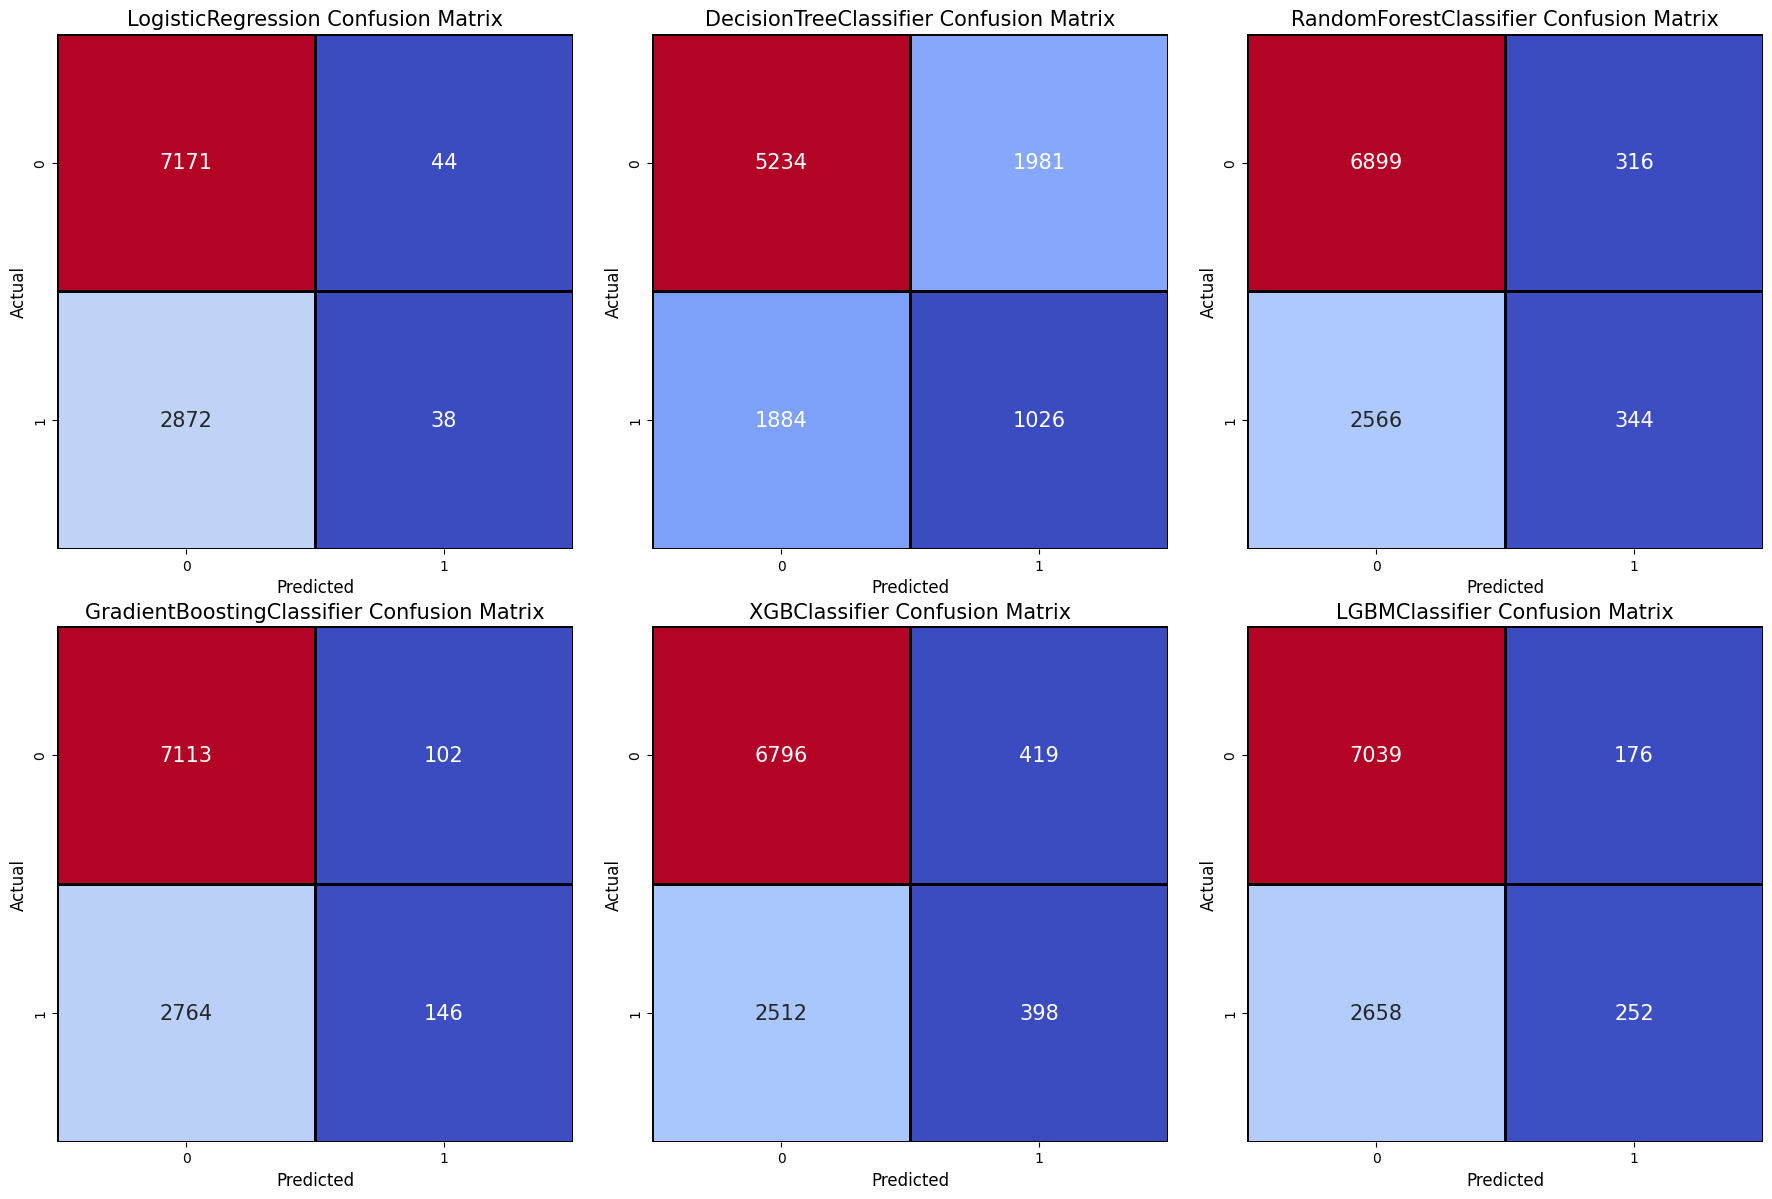

In [22]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import pre_data as eda
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_validate


# 모델 평가 함수 (크로스 밸리데이션 적용)
def evaluate_model_cv(model, X, y, cv):
    scoring = {
        'accuracy': 'accuracy',
        'f1': make_scorer(f1_score),
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score)
    }
    # 크로스 밸리데이션 평가 지표
    # cross_validate를 사용하여 여러 성능 지표를 계산
    scores = cross_validate(model, X, y, cv=cv, scoring=scoring, return_train_score=False)
    
    # scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')  # F1 스코어로 평가
    # return np.mean(scores), np.std(scores)
    
    # 각 메트릭의 평균과 표준편차를 계산
    mean_acc = scores['test_accuracy'].mean()
    mean_f1 = scores['test_f1'].mean()
    mean_precision = scores['test_precision'].mean()
    mean_recall = scores['test_recall'].mean()
    
    return mean_acc, mean_f1, mean_precision, mean_recall

# 1. 데이터 불러오기 및 전처리
data = pd.read_csv('./data/train.csv', encoding='cp949')
preprocessed_data = eda.preprocessing(data)

object_columns = preprocessed_data.select_dtypes(include=['object'])
convert_data, _ = eda.convert_category_into_integer(preprocessed_data, object_columns)

# 타겟 변수 및 독립 변수 설정
X = convert_data.drop('Churn', axis=1).astype(float)
y = convert_data['Churn'].astype(float)  # 이진 분류

# 모델 리스트 (가중치 balanced 적용)
# models = [
#     ('LogisticRegression', LogisticRegression(class_weight='balanced')),
#     ('DecisionTreeClassifier', DecisionTreeClassifier(class_weight='balanced')),
#     ('RandomForestClassifier', RandomForestClassifier(class_weight='balanced')),
#     ('GradientBoostingClassifier', GradientBoostingClassifier()),
#     ('XGBClassifier', XGBClassifier(scale_pos_weight=y.value_counts()[0] / y.value_counts()[1])),
#     ('LGBMClassifier', LGBMClassifier(scale_pos_weight=y.value_counts()[0] / y.value_counts()[1]))
# ]
models = [
    ('LogisticRegression', LogisticRegression()),
    ('DecisionTreeClassifier', DecisionTreeClassifier()),
    ('RandomForestClassifier', RandomForestClassifier()),
    ('GradientBoostingClassifier', GradientBoostingClassifier()),
    ('XGBClassifier', XGBClassifier()),
    ('LGBMClassifier', LGBMClassifier())
]

# 2. 데이터셋 분할 및 PCA 적용
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# 3. PCA를 사용해 상관관계가 높은 피처 병합
X_train_pca, X_test_pca = eda.pca_merge_correlated_columns(X_train, X_test,0.1,)
# 4. 데이터 스케일링
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_pca), columns=X_train_pca.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_pca), columns=X_test_pca.columns)

# 5. 크로스 밸리데이션 설정
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

# 6. 모델 성능 평가 및 결과 저장
results = []

for name, model in models:
    # mean_acc, std_acc = evaluate_model_cv(model, X_train_scaled, y_train, cv)
    mean_acc, mean_f1, mean_precision, mean_recall = evaluate_model_cv(model, X_train_scaled, y_train, cv)
    results.append({
        'Model': name,
        'mean_acc': mean_acc,
        'mean_f1': mean_f1,
        'mean_precision': mean_precision,
        'mean_recall': mean_recall
    })

# 결과를 데이터프레임으로 변환
results_df = pd.DataFrame(results)

# 결과 데이터프레임 정렬
results_df = results_df.set_index('Model')
results_df = results_df.sort_values(by='mean_acc', ascending=False)
print(results_df)


def plot_confusion_matrices(models, X_train_scaled, X_test_scaled, y_train, y_test):
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))  # Subplot for each model
    axes = axes.flatten()

    for idx, (name, model) in enumerate(models):
        # Fit the model and predict
        model.fit(X_train_scaled, y_train)
        y_pred_test = model.predict(X_test_scaled)
        
        # Generate confusion matrix
        cm = confusion_matrix(y_test, y_pred_test)
        # 테스트 데이터 성능 지표 계산
        test_acc = accuracy_score(y_test, y_pred_test)
        test_f1 = f1_score(y_test, y_pred_test)
        test_precision = precision_score(y_test, y_pred_test)
        test_recall = recall_score(y_test, y_pred_test)
        # Plot confusion matrix
        results.append({
            'Model': name,
            'mean_acc_cv': mean_acc,
            'mean_f1_cv': mean_f1,
            'mean_precision_cv': mean_precision,
            'mean_recall_cv': mean_recall,
            'test_acc': test_acc,
            'test_f1': test_f1,
            'test_precision': test_precision,
            'test_recall': test_recall
        })

        sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', ax=axes[idx], cbar=False, 
                    linewidths=1, linecolor='black', square=True, annot_kws={"size": 15})
        
        axes[idx].set_title(f'{name} Confusion Matrix', fontsize=15)
        axes[idx].set_xlabel('Predicted', fontsize=12)
        axes[idx].set_ylabel('Actual', fontsize=12)
        axes[idx].tick_params(axis='both', labelsize=10)
    
    plt.tight_layout()
    plt.show()

# Call the function to plot confusion matrices
plot_confusion_matrices(models, X_train_scaled, X_test_scaled, y_train, y_test)